In [14]:
import pyFAI
#from pyFAI.detectors.mask_utils import Mask
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from plotnine import *#ggplot, aes, geom_line, labs, theme, ggtitle
import pandas as pd
import fabio
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
import os
import pygix as pg
from scipy.interpolate import interp1d
#from baseline import asymmetric_least_squares
#from peakutils.baseline import asls

In [58]:
# Load the calibration file
poni_file = "/home/goughl/Documents/beamtime_data/2304_DLS/calib/20keV_geometry.poni"
calibration = pyFAI.load(poni_file) # this part done in pyFAI-calib2 GUI
mask_file = "/home/goughl/Documents/beamtime_data/2304_DLS/calib/mask_AgBh.edf"
mask = fabio.open(mask_file).data



# integrator function with arguments defined in pyFAI documentation
integrator = AzimuthalIntegrator(
    detector=calibration.detector,
    wavelength=calibration.wavelength,
    dist=calibration.dist,  
    poni1=calibration.poni1,
    poni2=calibration.poni2,
    rot1=calibration.rot1,
    rot2=calibration.rot2,
    rot3=calibration.rot3
)

# example arguments
# q, I = integrator.integrate1d(data, 1000, unit="q_A^-1", azimuth_range=(0, 90),radial_range=(0.15, 1.8), polarization_factor=0.99)

In [57]:
# # individually importing files from a folder (very slow and janky)

# data_file1 = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019282.tif"
# data1 = fabio.open(data_file1).data

# data_file2 = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019375.tif"
# data2 = fabio.open(data_file2).data

# data_file3 = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019426.tif"
# data3 = fabio.open(data_file3).data

# data_file4 = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019492.tif"
# data4 = fabio.open(data_file4).data

# data_file5 = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019541.tif"
# data5 = fabio.open(data_file5).data

# data_file6 = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019585.tif"
# data6 = fabio.open(data_file6).data

# data_file7 = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019630.tif"
# data7 = fabio.open(data_file7).data

# data_file8 = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019682.tif"
# data8 = fabio.open(data_file8).data



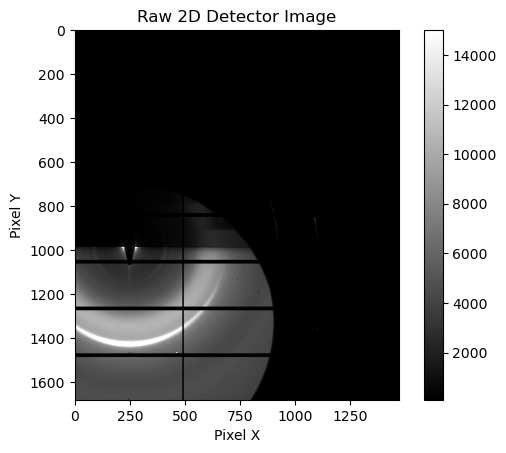

In [59]:
#plot the raw tif image

image = fabio.open("/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019682.tif")  # Replace with the actual path to your image file
data = image.data  

vmin = 100  # min intensity value
vmax = 15000  # max intensity value

# for long exposure images (t ~ 30 s) vmax ~ 15000
# for short exposure images (t ~ 3 s) vmax ~ 1000


plt.imshow(data, cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Raw 2D Detector Image')
plt.show()


In [80]:
# check you're in the right folder 
# lists all the files in a directory and puts them in numerical roder

folder_path = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure"

files = [filename for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename)) and filename.endswith('.tif')]
sorted_files = sorted(files, key=lambda x: int(x.split("p2mImage")[1].split(".")[0]))

for filename in sorted_files:
    print(filename)

p2mImage1019282.tif
p2mImage1019375.tif
p2mImage1019426.tif
p2mImage1019492.tif
p2mImage1019541.tif
p2mImage1019585.tif
p2mImage1019630.tif
p2mImage1019682.tif


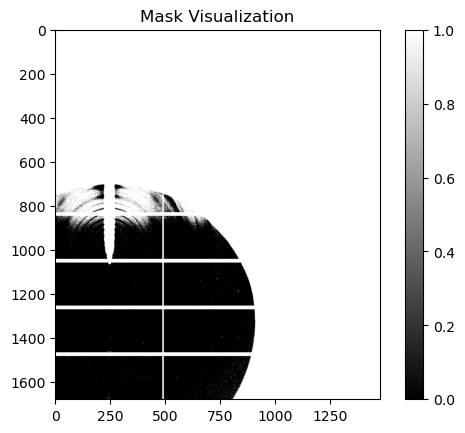

In [81]:
# visualise the mask

mask_data = fabio.open(mask_file).data
plt.imshow(mask_data, cmap='gray')
plt.colorbar()
plt.title("Mask Visualization")
plt.show()

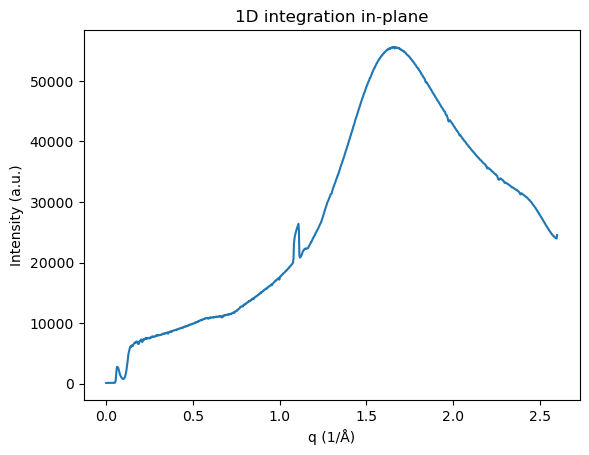

In [77]:
# plot the integrated data (individual)

data_file = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/DCV5T_40nm/p2mImage1019682.tif"
data = fabio.open(data_file1).data
#data = np.where(mask, data, 0) 
# uncomment the line above to mask

q, I = integrator.integrate1d(data, 1000, unit="q_A^-1", azimuth_range=(0 , 30), radial_range=(0.0, 2.6), polarization_factor=0.99)

# 90 to 120 is out of plane i think??
# 0 to 30 in plane? not 100% sure

plt.plot(q, I)
plt.xlabel("q (1/Å)")
plt.ylabel("Intensity (a.u.)")
plt.title("1D integration in-plane")
plt.show()


In [35]:
# # plotting multiple 1D integrations on same graph, not normalised

# # very primitive data importing for individual samples

# q1, I1 = integrator.integrate1d(data1, 1000, unit="q_A^-1", azimuth_range=(90, 120), radial_range=(0.5, 2.6), polarization_factor=0.99)
# q2, I2 = integrator.integrate1d(data2, 1000, unit="q_A^-1", azimuth_range=(90, 120), radial_range=(0.5, 2.6), polarization_factor=0.99)
# q3, I3 = integrator.integrate1d(data3, 1000, unit="q_A^-1", azimuth_range=(90, 120), radial_range=(0.5, 2.6), polarization_factor=0.99)
# q4, I4 = integrator.integrate1d(data4, 1000, unit="q_A^-1", azimuth_range=(90, 120), radial_range=(0.5, 2.6), polarization_factor=0.99)


# plt.plot(q1, I1, label='~ 5 nm')
# plt.plot(q2, I2, label='~10 nm')
# plt.plot(q3, I3, label='~ 25 nm')
# plt.plot(q4, I4, label='~ 40 nm')


# plt.xlabel("q (1/Å)")
# plt.ylabel("Intensity (a.u.)")
# plt.title("1D integration in-plane \n DCV5T RT")


# plt.legend()
# plt.show()

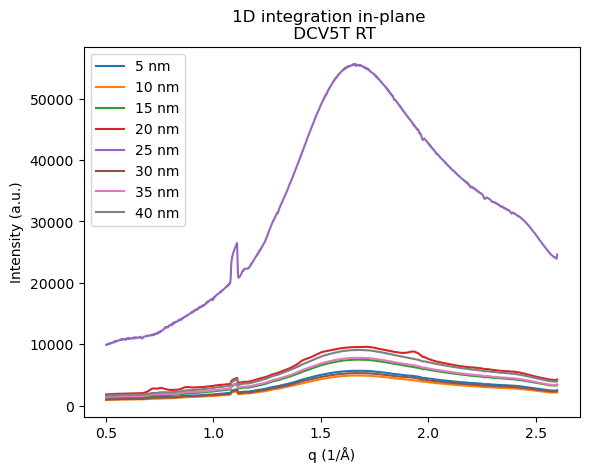

In [79]:

folder_path = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure"
output_folder = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure"  # Specify the desired output folder
# enter the filepath where you want the CSVs to be saved


qs = []
Is = []
labels = []

start_label = 5
for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        data = fabio.open(os.path.join(folder_path, filename)).data
        #data = np.where(mask, data, 0)
        # can't get the mask to behave properly
        q, I = integrator.integrate1d(data, 1000, unit="q_A^-1", azimuth_range=(0, 30), radial_range=(0.5, 2.6), polarization_factor=0.99)
        label = start_label + 5 * len(qs)
        qs.append(q)
        Is.append(I)
        labels.append(label)

save = False
# change to true when you want to save the files

if save == True:
    for filename, q, I, label in zip(os.listdir(folder_path), qs, Is, labels):
        data = {'q': q, 'Intensity': I}
        df = pd.DataFrame(data)
        base_filename = os.path.splitext(filename)[0]  
        output_filename = os.path.join(output_folder, f"integration_{base_filename}_{label}nm_unnormalised.csv")
        # change this according to how you want to 
        df.to_csv(output_filename, index=False)

        plt.plot(q, I, label=f"{label} nm")        
else:
    for q, I, label in zip(qs, Is, labels):
        plt.plot(q, I, label=f"{label} nm")

plt.xlabel("q (1/Å)")
plt.ylabel("Intensity (a.u.)")
plt.title("1D integration in-plane \n DCV5T RT")

plt.legend()
plt.show()



In [29]:
# # normalise to a peak in a chosen range

# # min intensity in given range
# max_peak1 = min(I1[(q1 > 2.5) & (q1 < 2.6)])
# max_index1 = np.argmin(I1[(q1 > 2.5) & (q1 < 2.6)])
# q_max_peak1 = q1[(q1 > 2.5) & (q1 < 2.6)][max_index1]

# max_peak2 = min(I2[(q2 > 2.5) & (q2 < 2.6)])
# max_index2 = np.argmin(I2[(q2 > 2.5) & (q2 < 2.6)])
# q_max_peak2 = q2[(q2 > 2.5) & (q2 < 2.6)][max_index2]
# # # if doing the min intensity, choose region in 2D scans where there's no rings and just background

# max_peak3 = min(I3[(q3 > 2.5) & (q3 < 2.6)])
# max_index3 = np.argmin(I3[(q3 > 2.5) & (q3 < 2.6)])
# q_max_peak3 = q3[(q3 > 2.5) & (q3 < 2.6)][max_index3]

# max_peak4 = min(I4[(q4 > 2.5) & (q4 < 2.6)])
# max_index4 = np.argmin(I4[(q4 > 2.5) & (q4 < 2.6)])
# q_max_peak4 = q4[(q4 > 2.5) & (q4 < 2.6)][max_index4]



# # # max intensity in given range
# # max_peak1 = max(I1[(q1 > 0.25) & (q1 < 0.5)])
# # q_max_peak1 = q1[(q1 > 0.25) & (q1 < 0.5)][max_index]

# # max_peak2 = max(I2[(q2 > 0.25) & (q2 < 0.5)])
# # q_max_peak2 = q2[(q2 > 0.25) & (q2 < 0.5)][max_index]
# # use this when you know 2 peaks should be similar intensity

# I_norm1 = I1 / max_peak1
# I_norm2 = I2 / max_peak2
# I_norm3 = I3 / max_peak3
# I_norm4 = I4 / max_peak4

# plt.plot(q1, I_norm1, label="5")
# plt.plot(q2, I_norm2, label="10")
# plt.plot(q3, I_norm3, label="15")
# plt.plot(q4, I_norm4, label="20")
# # plt.plot(q3, I_norm3, label="blend temp")
# # plt.plot(q4, I_norm4, label="blend no temp")

# plt.xlabel("q (1/Å)")
# plt.ylabel("Normalised intensity")
# plt.title("1D integration in plane")
# plt.title("1D integration out of plane") # just plots in default matplotlib settings

# plt.legend()
# plt.show()

# # print the co-ords of the normalising peak, make sure they're the same
# print("Peak 1 coordinates: q = {:.4f}, I = {:.4f}".format(q_max_peak1, max_peak1)) 
# print("Peak 2 coordinates: q = {:.4f}, I = {:.4f}".format(q_max_peak2, max_peak2))

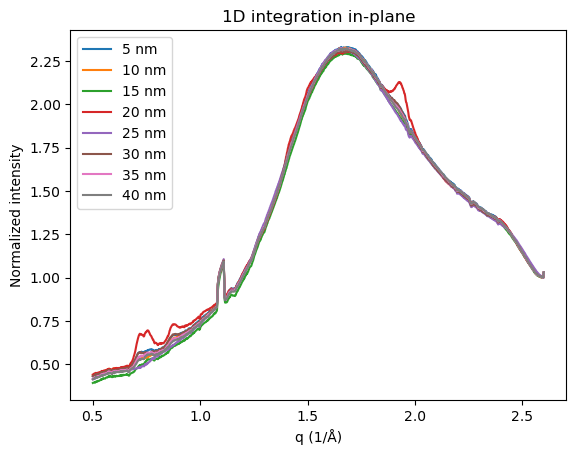

Peak 1 coordinates: q = 2.5969, I = 2436.7891
Peak 2 coordinates: q = 2.5885, I = 2113.4221
Peak 3 coordinates: q = 2.5927, I = 3264.6387
Peak 4 coordinates: q = 2.5969, I = 4146.9214
Peak 5 coordinates: q = 2.5969, I = 23933.4160
Peak 6 coordinates: q = 2.5969, I = 2295.1235
Peak 7 coordinates: q = 2.5927, I = 3355.0881
Peak 8 coordinates: q = 2.5969, I = 3907.8398


In [28]:
background_q = 2.6 # choose a q value where there is only background
bg_range = 0.05


normalized_intensities = []
peak_coordinates = []


for i, (q, I) in enumerate(zip(qs, Is)):
    max_peak = min(I[(q > background_q - bg_range) & (q < background_q + bg_range)])
    max_index = np.argmin(I[(q > background_q - bg_range) & (q < background_q + bg_range)])
    q_max_peak = q[(q > background_q - bg_range) & (q < background_q + bg_range)][max_index]

    normalized_intensity = I / max_peak
    normalized_intensities.append(normalized_intensity)
    peak_coordinates.append((q_max_peak, max_peak))

    plt.plot(q, normalized_intensity, label=f"{labels[i]} nm")

plt.xlabel("q (1/Å)")
plt.ylabel("Normalized intensity")
plt.title("1D integration in-plane")
plt.legend()
plt.show()

# Print the coordinates of the normalizing peaks
for i, (q_max_peak, max_peak) in enumerate(peak_coordinates):
    print(f"Peak {i + 1} coordinates: q = {q_max_peak:.4f}, I = {max_peak:.4f}")


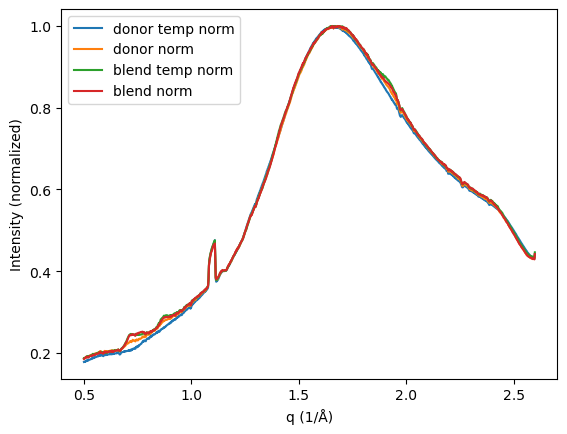

In [18]:
# normalises data to highest intensity peak 

I_norm1 = I1 / max(I1)
I_norm2 = I2 / max(I2)
I_norm3 = I3 / max(I3)
I_norm4 = I4 / max(I4)

plt.plot(q1, I_norm1, label="donor temp norm")
plt.plot(q2, I_norm2, label="donor norm")
plt.plot(q3, I_norm3, label="blend temp norm")
plt.plot(q4, I_norm4, label="blend norm")
plt.xlabel("q (1/Å)")
plt.ylabel("Intensity (normalized)")
plt.legend()
plt.show()

# also good normalisation, this one quicker

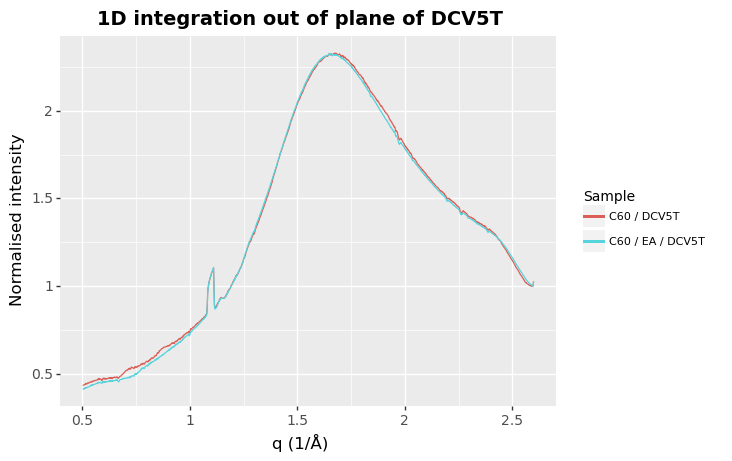

<ggplot: (8737922512440)>

In [84]:
# normalised data in pretty plotnine plot

df = pd.DataFrame({'q': q1, 'I_norm': I_norm1, 'Sample': ['C60 / EA / DCV5T']*len(q1)})
df2 = pd.DataFrame({'q': q2, 'I_norm': I_norm2, 'Sample': ['C60 / DCV5T']*len(q2)})
df3 = pd.DataFrame({'q': q3, 'I_norm': I_norm3, 'Sample': ['C60 / EA / DCV5T:C60']*len(q3)})
df4 = pd.DataFrame({'q': q4, 'I_norm': I_norm4, 'Sample': ['C60 / DCV5T:C60']*len(q4)})
df = pd.concat([df, df2], axis=0)


plot = (ggplot(df, aes(x='q', y='I_norm', color='Sample'))
        + geom_line()
        + labs(x='q (1/Å)', y='Normalised intensity')
        + ggtitle('1D integration out of plane of DCV5T')
        #+ theme_classic()
        + theme(plot_title=element_text(size=14, weight='bold'),
                legend_title=element_text(size=10),
                legend_text=element_text(size=8),
                axis_text=element_text(size=10),
                axis_title=element_text(size=12))
       )

plot


In [8]:
# # data smoothing

# # Savitzky-Golay filter with a window size and polynomial order (from scipy)
# I_norm1_smooth = savgol_filter(I_norm1, 21, 3)
# I_norm2_smooth = savgol_filter(I_norm2, 21, 3)


# df_smooth = pd.DataFrame({'q': q1, 'I_norm': I_norm1_smooth, 'Sample': ['PM6:PC71BM (S4)']*len(q1)})
# df2_smooth = pd.DataFrame({'q': q2, 'I_norm': I_norm2_smooth, 'Sample': ['PM6:ITIC-4F (S5)']*len(q2)})
# df_smooth = pd.concat([df_smooth, df2_smooth], axis=0)


# plot = (ggplot(df_smooth, aes(x='q', y='I_norm', color='Sample'))
#         + geom_line()
#         + xlab('q (1/Å)')
#         + ylab('Smoothed normalised intensity')
#         + ggtitle('1D integration out of plane')
#         #+ theme_classic() # uncomment if you want a white background / no gridlines
#         + theme(plot_title=element_text(size=14, weight='bold'),
#                 legend_title=element_text(size=10),
#                 legend_text=element_text(size=8),
#                 axis_text=element_text(size=10),
#                 axis_title=element_text(size=12))
#        )

# plot

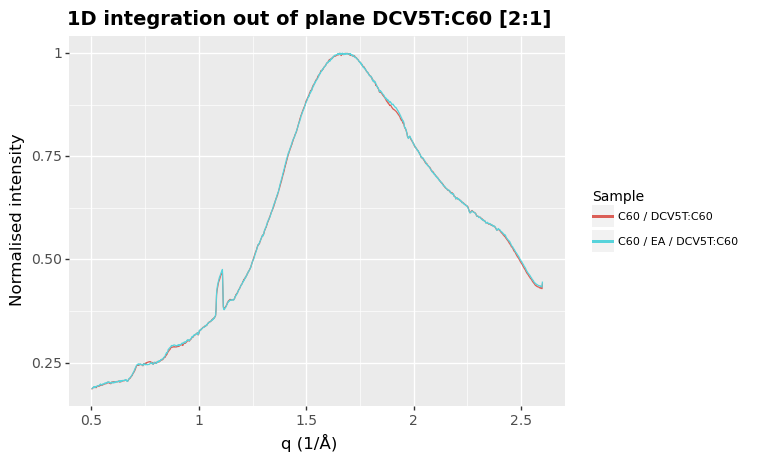

<ggplot: (8737925761640)>

In [85]:
df = pd.concat([df3, df4], axis=0)

plot = (ggplot(df, aes(x='q', y='I_norm', color='Sample'))
        + geom_line()
        + xlab('q (1/Å)')
        + ylab('Normalised intensity')
        + ggtitle('1D integration out of plane DCV5T:C60 [2:1]')
        #+ theme_classic()
        + theme(plot_title=element_text(size=14, weight='bold'),
                legend_title=element_text(size=10),
                legend_text=element_text(size=8),
                axis_text=element_text(size=10),
                axis_title=element_text(size=12))
       )

plot

*To do:*

- make ```baseline``` package work
- remove baselines using ```asymmetric_least_squares``` function
- do in plane and out of plane plots for donor and blend pairs
